In [56]:
import flappy_bird_gymnasium
from flappy_bird_gymnasium.envs import flappy_bird_env
from flappy_bird_gymnasium.envs import utils
from flappy_bird_gymnasium.envs.constants import (
    BACKGROUND_WIDTH,
    BASE_WIDTH,
    FILL_BACKGROUND_COLOR,
    LIDAR_MAX_DISTANCE,
    PIPE_HEIGHT,
    PIPE_VEL_X,
    PIPE_WIDTH,
    PLAYER_ACC_Y,
    PLAYER_FLAP_ACC,
    PLAYER_HEIGHT,
    PLAYER_MAX_VEL_Y,
    PLAYER_PRIVATE_ZONE,
    PLAYER_ROT_THR,
    PLAYER_VEL_ROT,
    PLAYER_WIDTH,
)
import gymnasium
import numpy as np
import torch
from torch import nn
import random
from collections import deque
from collections import namedtuple
import matplotlib.pyplot as plt
import time
import math

In [57]:
#Hyperparameters
env = gymnasium.make('FlappyBird-v0', use_lidar = False,normalize_obs=True)
device = torch.device("mps")
batch_size = 128
buffer_replay_capacity = 200000
actions = torch.tensor([0, 1])
eps_start = 1
learning_rate = 0.0005
gamma = 0.99
eps_end = 0.01                           
eps_decay = 0.00001
target_update = 1000


n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
print(n_states, n_actions)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', "Terminal"))


12 2


#### Replay Memory - Memorizing the data from the played )

In [58]:
class ReplayMemory():
    def __init__(self, buffer_replay_capacity,n_states):
        self.buffer_replay_capacity = buffer_replay_capacity
        self.memory_step = 0
        self.state_memory = torch.zeros((buffer_replay_capacity, n_states), dtype=torch.float32, device=device)
        self.next_state_memory = torch.zeros((buffer_replay_capacity, n_states), dtype=torch.float32, device=device)
        self.action_memory = torch.zeros(buffer_replay_capacity, dtype=torch.int32, device=device)
        self.reward_memory = torch.zeros(buffer_replay_capacity, dtype=torch.float32, device=device)
        self.Terminal_memory = torch.zeros(buffer_replay_capacity, dtype=torch.bool, device=device)
        
    def push(self, Transition):
        memory_index = self.memory_step % self.buffer_replay_capacity
        self.state_memory[memory_index] = Transition.state
        self.next_state_memory[memory_index] = Transition.next_state
        self.action_memory[memory_index] = Transition.action
        self.reward_memory[memory_index] = Transition.reward
        self.Terminal_memory[memory_index] = Transition.Terminal
        self.memory_step += 1

        
        
    def sample(self,batch_size):
        if self.memory_step < batch_size:
            return None
        max_possible_index = min(self.memory_step, self.buffer_replay_capacity)
        indices = torch.randint(0, max_possible_index, (batch_size,), device=device)
        return(
            self.state_memory[indices],
            self.action_memory[indices],
            self.next_state_memory[indices],
            self.reward_memory[indices],
            self.Terminal_memory[indices])
    def __len__(self):
        if self.memory_step < self.buffer_replay_capacity:
            return self.memory_step
        else:
            return self.buffer_replay_capacity

#### Deep Q Network)


In [59]:
class DQN(nn.Module):
    def __init__(self, n_states, n_actions):
        super(DQN, self).__init__()
        hidden_layers = 64
        self.fc = nn.Sequential(
            nn.Linear(n_states, hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, n_actions)
        )

    def forward(self, x):
        return self.fc(x)

memory = ReplayMemory(buffer_replay_capacity,n_states)


rewards_list = []
pipes_passed_list = []
losses_list = []
steps_per_episode = []
vertical_distance_list = []


policy_net = DQN(n_states, n_actions).to(device)
target_net = DQN(n_states, n_actions).to(device)
total_step_count = 0
steps_per_gradient_update = 6


optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

episode_step_limit = 5000



#### The Agent Playing - Training)

Episode: 1, Step: 5, Action: 0, Reward: -0.1, Total Reward: -0.5, Epsilon: 0
Episode: 1, Step: 11, Action: 0, Reward: -0.1, Total Reward: -1.0999999999999999, Epsilon: 0
Episode: 1, Step: 17, Action: 0, Reward: -0.1, Total Reward: -1.7000000000000004, Epsilon: 0
Episode: 1, Step: 23, Action: 0, Reward: -0.1, Total Reward: -2.3000000000000007, Epsilon: 0
Episode: 1, Step: 29, Action: 0, Reward: -0.1, Total Reward: -2.9000000000000012, Epsilon: 0
Episode: 1, Step: 35, Action: 0, Reward: -0.1, Total Reward: -3.5000000000000018, Epsilon: 0
Episode: 1, Step: 41, Action: 0, Reward: 0.1, Total Reward: -2.9000000000000012, Epsilon: 0
Episode: 1, Step: 47, Action: 0, Reward: 0.1, Total Reward: -2.3000000000000007, Epsilon: 0
Episode: 1, Step: 53, Action: 0, Reward: 0.1, Total Reward: -1.7000000000000002, Epsilon: 0
Episode: 1, Step: 59, Action: 0, Reward: 0.1, Total Reward: -1.0999999999999996, Epsilon: 0
Episode: 1, Step: 65, Action: 0, Reward: 0.1, Total Reward: 4.399999999999999, Epsilon: 0


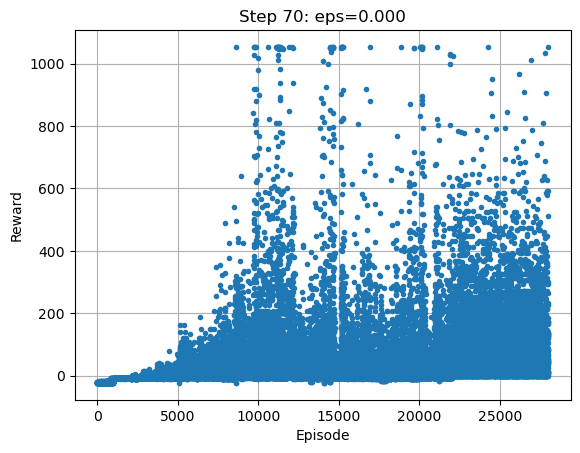

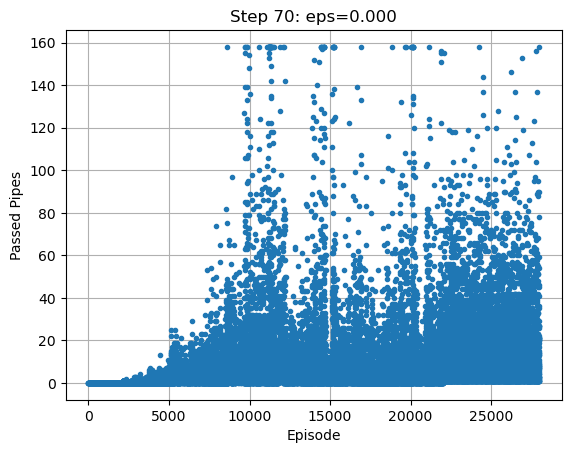

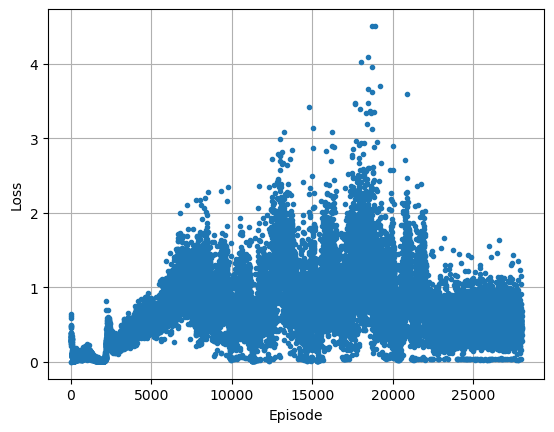

In [105]:

if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 28000
else:
    num_episodes = 50

for i in range(num_episodes):
    alive_counter = 0
    pass_the_pipe_counter = 0
    step_count = 0
    reward = 0
    episode_reward = 0
    episode_gradient_step = 0
    episode_loss = 0
    Terminal = False
    state = torch.tensor(env.reset()[0], dtype=torch.float32)
    state = state.float().to(device)
    while not Terminal and step_count < 6000:
        if random.random() < eps_start:   #randomize action
            action = torch.randint(0, n_actions, (1,)).item()
        else:               # optimal action
            action = policy_net(state).argmax().item()
       
                

        if eps_start > eps_end: # reduce epsilon as episodes go by, but keep it low until training is done 
            eps_start -= eps_decay
        if total_step_count > 50000: # no epsilon after enough training
            eps_start = 0

        next_state,reward,Terminal,_,info = env.step(action) # step environment
        if reward == 1:
            pass_the_pipe_counter += 1
            if pass_the_pipe_counter == 1:
                reward += 2
            reward += 2 # increase the normal reward of passing a pipe by 2 to encourage it more
        elif reward == -1:
            reward = -5
            Terminal = True 

        




        
    
        
 
        next_state = torch.tensor(next_state, dtype=torch.float32) 
        next_state = next_state.to(device)
        step_count += 1
        total_step_count += 1

        if next_state[4]-0.2 > next_state[9]> next_state[5]+0.2: # rewarding the agent for being closer to the pipes y-cooardinates
            reward += 0.5 
        if next_state[4]+0.3 < next_state[9] or next_state[9] < next_state[5]-0.3: # punishing the agent for having a y-coordinates that is far from the pipes
            reward -= 0.2
        #if next_state[11] > abs(0.8):     # next state[11] is the rotation of the bird within a 180 degree angle, hence encouraging the bird to stay closer to zero
            #reward -= 0.5





        
            
            
        

        episode_reward += reward # accumulate total reward for an episode
        
        
        memory.push(Transition(state, action, next_state, reward, Terminal)) #push the transition into the replay memory

        


        state = next_state #step up the state
       

        if (memory.__len__() > batch_size) and (total_step_count % steps_per_gradient_update == 0):
            
            state_batch, action_batch, next_state_batch, reward_batch, Terminal_batch = memory.sample(batch_size) #Separate the random batch from the memory into batches for each observation
            
        
            state_batch = state_batch.to(device)
            action_batch = action_batch.to(device)
            action_batch = action_batch.long()
            action_batch = action_batch.unsqueeze(1)
            
            
            reward_batch = reward_batch.to(device).unsqueeze(1)
            next_state_batch = next_state_batch.to(device)
            Terminal_batch = Terminal_batch.to(device)
            Terminal_batch = Terminal_batch.float().unsqueeze(1)

             
            

            q_values = policy_net(state_batch).gather(1, action_batch)
            #Select the optimal action 
            index_batch = policy_net(next_state_batch).argmax(1, keepdim=True)  # Shape [batch_size, 1]
            next_state_values = target_net(next_state_batch).gather(1, index_batch)  # Shape [batch_size, 1]
            y = reward_batch + gamma * next_state_values * (1 - Terminal_batch)  

            
            


            

            
            loss = loss_function(q_values, y)
            if not loss.requires_grad:
                loss.requires_grad = True
            
        
            


            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.5)
            optimizer.step()

            if total_step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict()) # transfer from the policy network to the target network


            episode_loss += loss.item()
            episode_gradient_step += 1
            print(f"Episode: {i+1}, Step: {step_count}, Action: {action}, Reward: {reward}, Total Reward: {episode_reward}, Epsilon: {eps_start}")
        

    rewards_list.append(episode_reward)
    losses_list.append(episode_loss / (episode_gradient_step+1))
    pipes_passed_list.append(pass_the_pipe_counter)
    steps_per_episode.append(step_count)
    print(f"Passed the pipe: {pass_the_pipe_counter} times")

    print_interval = 50

    if (i + 1) % print_interval == 0:
        average_reward = np.mean(rewards_list [-print_interval:-1])
        average_episode_steps = np.mean(steps_per_episode[-print_interval:-1])
        print(average_reward)
        print(f'Episode={i + 1}, Rewards={average_reward:.1f}, Steps={average_episode_steps:.0f}')

        # Plot scores        
        plt.figure('Rewards')
        plt.clf()
        plt.plot(np.array(rewards_list), '.')  
        plt.title(f'Step {step_count}: eps={eps_start:.3f}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.grid(True)

        plt.figure('Passed Pipe')
        plt.clf()
        plt.plot(np.array(pipes_passed_list), '.')  
        plt.title(f'Step {step_count}: eps={eps_start:.3f}')
        plt.xlabel('Episode')
        plt.ylabel('Passed Pipes')
        plt.grid(True)
        

        # Plot last batch loss
        plt.figure('Loss')
        plt.clf()
        plt.plot(np.array(losses_list), '.') 
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.grid(True)
        





#### Confidence Interval)

In [106]:
import scipy.stats as stats

mean = np.mean(pipes_passed_list[10000:])
std = np.std(pipes_passed_list[10000:],ddof = 1)
n = len(pipes_passed_list)

#chosen 95% confidence level

z = stats.norm.ppf(0.975)

margin_of_error = z * (std / np.sqrt(n))

ConfidenceInterval = mean + np.array([-1,1]) * margin_of_error

print(ConfidenceInterval,mean,margin_of_error)





[13.49705437 13.97772341] 13.737388888888889 0.24033452274408593
28000


#### Amount of Pipes)

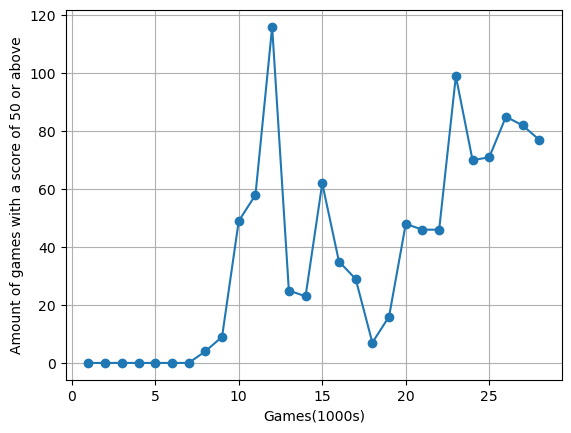

In [107]:
counts = []

num_batches = len(pipes_passed_list)//1000
for i in range(num_batches):

    pipes_passed_50 = np.array(pipes_passed_list[1000*i:1000*(i+1)])

    above_50 = len(pipes_passed_50[pipes_passed_50 >= 50])
    counts.append(above_50)


thousands_values = list(range(1, num_batches+1))  

# Plot the data
plt.figure('Numbers Plot')
plt.plot(thousands_values, counts, marker='o', linestyle='-')
plt.xlabel('Games(1000s)')
plt.ylabel('Amount of games with a score of 50 or above')
plt.grid(True)
plt.show()